# Memory Based Classification with QKM

A memory based classifier with  [Quantum kernel Mixtures](https://github.com/fagonzalezo/quakemix).

In [1]:
'''
Create a 2 moons dataset 
'''
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


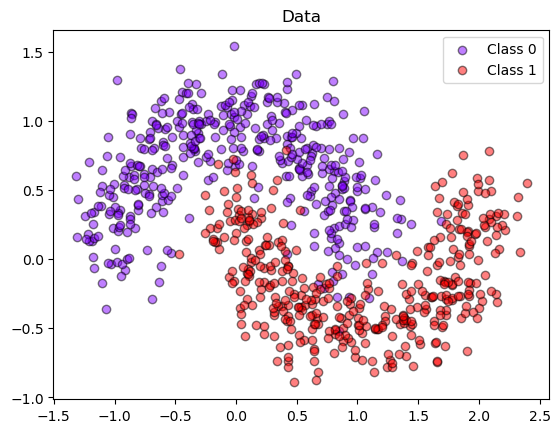

In [24]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun_mem(clf):
    def pred_fun(X):
        X_ds = clf.create_predict_ds(X)
        return clf.predict(X_ds)[:, 1]
    return pred_fun

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

plot_data(X_train, y_train)

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import tensorflow as tf

import qkm
from importlib import reload
reload(qkm);
reload(qkm.tf.layers.rbf_kernel_layer);reload(qkm.tf.layers.qkm_layer);
reload(qkm.tf.layers.mem_qkm_layer);reload(qkm.tf.models.mem_qkm_class_model);
reload(qkm.tf.layers);reload(qkm.tf.models);

## Memory QKM Model

First we pretrain a QKM Model for a few epochs and use the learned encoder for a Memory Based QKM Classifier.

In [20]:
from qkm.tf.models import MemQKMClassModel, QKMClassModel


encoded_size = 10
dim_y = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(encoded_size, activation='linear', input_shape=(2,)),
])  
n_comp = 20

qkm_model = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=1.)

qkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_model.init_components(X_train[idx], 
                          np.eye(2)[y_train[idx]],
                          init_sigma=True)
print(f"Initial sigma: {qkm_model.kernel.sigma.numpy()}")
qkm_model.fit(X_train, y_train, epochs=2, batch_size=32)
print(f"FInal sigma: {qkm_model.kernel.sigma.numpy()}")


Initial sigma: 0.7800304889678955
Epoch 1/2


2023-08-21 10:37:48.120556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 2s 43ms/step - loss: 0.3615 - sparse_categorical_accuracy: 0.8350
Epoch 2/2
25/25 [==============================] - 1s 25ms/step - loss: 0.3034 - sparse_categorical_accuracy: 0.8587
FInal sigma: 0.7317646145820618


We evaluate the performance of the classifier on the test set.

In [21]:
score = qkm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
score = qkm_model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

2023-08-21 10:37:53.170053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.2838107645511627
Test accuracy: 0.8650000095367432
Train loss: 0.2787265479564667
Train accuracy: 0.8712499737739563


2023-08-21 10:40:39.935920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 15ms/step
0.0010316691 0.0010316691


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


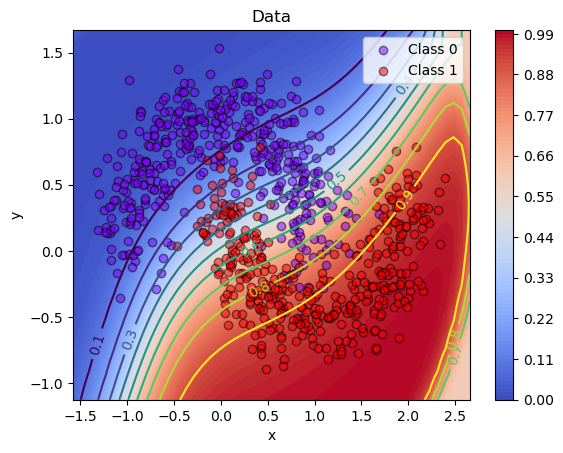

In [25]:
plot_decision_region(X, gen_pred_fun(qkm_model))
plot_data(X_train, y_train)


Since the model is trained for few epochs, the performance is not very good. Now we use the same encoder with a Memory Based QKM Classifier.

In [38]:
from qkm.tf.models import MemQKMClassModel, QKMClassModel


encoded_size = 10
dim_y = 2
n_comp = 50

mqkm_model = MemQKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=qkm_model.kernel.sigma.numpy())

# init the memory
mqkm_model.create_index(X_train, np.eye(dim_y)[y_train])
X_train_ds = mqkm_model.create_train_ds(batch_size=32)
X_test_ds = mqkm_model.create_test_ds(X_test, np.eye(dim_y)[y_test], batch_size=32)
X_pred_ds = mqkm_model.create_predict_ds(X_test)

# train the classifier
mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")

2023-08-21 10:45:59.308872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Initial sigma: 0.7317646145820618


In [39]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

2023-08-21 10:46:04.421824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-21 10:46:04.437609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-21 10:46:04.863882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.09216485917568207
Test accuracy: 0.9700000286102295


2023-08-21 10:46:05.937689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.97


In [40]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

Test loss: 0.09216485917568207
Test accuracy: 0.9700000286102295
Accuracy: 0.97


16/79 [=====>........................] - ETA: 0s

2023-08-21 10:46:12.139096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 8ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


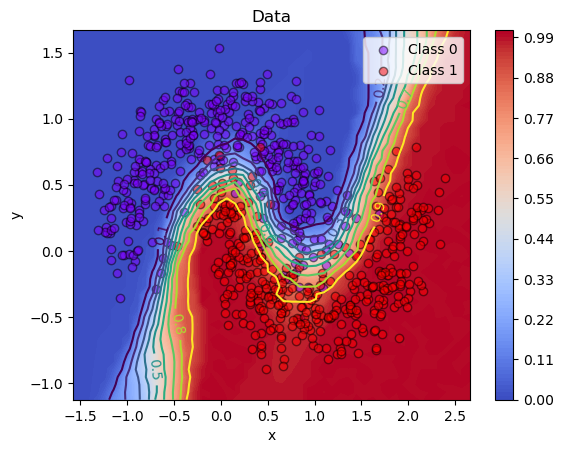

In [41]:
plot_decision_region(X, gen_pred_fun_mem(mqkm_model))
plot_data(X_train, y_train)


The performance is much better. We can fine tune the sigma parameter.

In [42]:

# train the classifier
mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")
mqkm_model.fit(X_train_ds, epochs=5, verbose=1)
print(f"FInal sigma: {mqkm_model.kernel.sigma.numpy()}")


Initial sigma: 0.7317646145820618
Epoch 1/5


2023-08-21 10:46:24.436871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 3s 54ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1022 - categorical_accuracy: 0.9650
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 0.1021 - categorical_accuracy: 0.9650
Epoch 5/5
25/25 [==============================] - 1s 20ms/step - loss: 0.1021 - categorical_accuracy: 0.9650
FInal sigma: 0.6527519822120667


2023-08-21 10:46:32.810333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.09174356609582901
Test accuracy: 0.9750000238418579


2023-08-21 10:46:33.875537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Accuracy: 0.975
12/79 [===>..........................] - ETA: 0s

2023-08-21 10:46:34.417219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 9ms/step
0.0 0.0


/var/folders/p_/nhqsddwd6w3923l9m2_nxxzm0000gp/T/ipykernel_92685/1636652363.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,


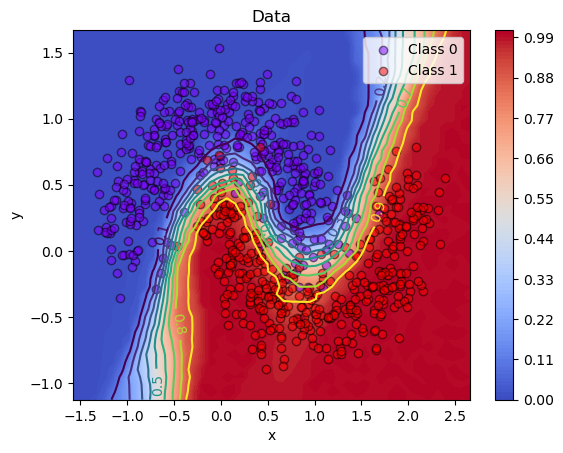

In [43]:
from sklearn.metrics import accuracy_score
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred_y = mqkm_model.predict(X_pred_ds, verbose=0)
pred_y = np.argmax(pred_y, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, pred_y)))

plot_decision_region(X, gen_pred_fun_mem(mqkm_model))
plot_data(X_train, y_train)


## MNIST example

An example using the mnist dataset. In addition to perform classification we will show how to perform generation.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
from keras import losses
from keras import metrics
import qkm
import tensorflow as tf

from importlib import reload
reload(qkm);

In [2]:
# Create a dataset from mnist using tf
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


# reshape the data to include a channel dimension
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Partition the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
      x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
      fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
      axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
      axs.flat[i].axis('off')
    plt.show()
    plt.close()
    plt.ion()


We define a deep encoder that will be used to map input images to a low-dimensional latent space.

In [3]:
tfkl = tf.keras.layers

def create_encoder(input_shape, base_depth, encoded_size, l2_reg=0.):
    encoder = tf.keras.Sequential([
        tfkl.InputLayer(input_shape=input_shape),
        tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
        tfkl.Conv2D(base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=1,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(2 * base_depth, 5, strides=2,
                    padding='same', activation=tf.nn.leaky_relu),
        tfkl.Conv2D(4 * encoded_size, 7, strides=1,
                    padding='valid', activation=tf.nn.leaky_relu),
        (tfkl.Dense(encoded_size, activation=None) if l2_reg == 0.
         else   tfkl.Dense(encoded_size, 
                           activation=None, 
                           activity_regularizer=tf.keras.regularizers.l2(1e-3))),
        tfkl.Flatten(),
    ])
    return encoder

The classifier model (QKMClassModel) receives as input the encoder, and applies it before applying the QKM inference layer.

In [4]:
from qkm.tf.models import QKMClassModel, MemQKMClassModel
# Define the encoder
input_shape = (28, 28, 1)
base_depth = 32
encoded_size = 16
encoder1 = create_encoder(input_shape, base_depth, encoded_size, l2_reg=1e-3)

# warm up the encoder
enc_model = tf.keras.Sequential([encoder1,
                tf.keras.layers.Dense(10, activation='softmax')])
enc_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                loss=losses.sparse_categorical_crossentropy,
                metrics=[metrics.sparse_categorical_accuracy])
enc_model.fit(X_train, y_train, epochs=1, batch_size=128)

score = enc_model.evaluate(X_test, y_test, verbose=0)
print('Base encoder test loss:', score[0])
print('Base encoder test accuracy:', score[1])
score = enc_model.evaluate(X_train, y_train, verbose=0)
print('Base encoder train loss:', score[0])
print('Base encoder train accuracy:', score[1])


# Create a classifier model
dim_y = 10
n_comp = 64

qkm_mnist = QKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder1,
                            n_comp=n_comp,        
                            sigma=0.1)

# initialize the prototypes using random samples from the training set
idx = np.random.randint(X_train.shape[0], size=n_comp)
qkm_mnist.init_components(X_train[idx], tf.one_hot(y_train[idx], 10), 
                          init_sigma=True, sigma_mult=0.1)

print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

# Compile the model
qkm_mnist.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])

# Evaluate the classifier
score = qkm_mnist.evaluate(X_test, y_test, verbose=0)
print('QKM test loss:', score[0])
print('QKM test accuracy:', score[1])
score = qkm_mnist.evaluate(X_train, y_train, verbose=0)
print('QKM train loss:', score[0])
print('QKM train accuracy:', score[1])
print(f'Sigma: {qkm_mnist.kernel.sigma.numpy()}')

2023-08-23 15:12:12.347275: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-23 15:12:12.347302: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-23 15:12:12.347309: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-23 15:12:12.347347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 15:12:12.347367: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-23 15:12:13.130028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 27s 69ms/step - loss: 0.5314 - sparse_categorical_accuracy: 0.8269


2023-08-23 15:12:39.766987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Base encoder test loss: 0.4088898003101349
Base encoder test accuracy: 0.8697999715805054


Base encoder train loss: 0.37131190299987793
Base encoder train accuracy: 0.882479190826416
Sigma: 0.8468660116195679


2023-08-23 15:13:04.585133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


QKM test loss: 1.1993921995162964
QKM test accuracy: 0.7444000244140625
QKM train loss: 1.1721082925796509
QKM train accuracy: 0.7553125023841858
Sigma: 0.8468660116195679


In [9]:
# create callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
earlystop = EarlyStopping(monitor='val_categorical_accuracy', patience=5,
                           verbose=1, restore_best_weights=True)

# Train the model
qkm_mnist.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=20, batch_size=128, verbose=1,
              callbacks=[earlystop])
print(f'Final Sigma: {qkm_mnist.kernel.sigma.numpy()}')


Epoch 1/20


2023-08-23 15:14:52.067013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.4925 - sparse_categorical_accuracy: 0.8517WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 75ms/step - loss: 0.4925 - sparse_categorical_accuracy: 0.8517 - val_loss: 0.3744 - val_sparse_categorical_accuracy: 0.8770
Epoch 2/20
375/375 [==============================] - ETA: 0s - loss: 0.2966 - sparse_categorical_accuracy: 0.8984WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 29s 76ms/step - loss: 0.2966 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.2980 - val_sparse_categorical_accuracy: 0.8945
Epoch 3/20
375/375 [==============================] - ETA: 0s - loss: 0.2553 - sparse_categorical_accuracy: 0.9100WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 28s 76ms/step - loss: 0.2553 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.2842 - val_sparse_categorical_accuracy: 0.8970
Epoch 4/20
375/375 [==============================] - ETA: 0s - loss: 0.2305 - sparse_categorical_accuracy: 0.9187WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 29s 76ms/step - loss: 0.2305 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.2764 - val_sparse_categorical_accuracy: 0.9027
Epoch 5/20
375/375 [==============================] - ETA: 0s - loss: 0.2017 - sparse_categorical_accuracy: 0.9295WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 80ms/step - loss: 0.2017 - sparse_categorical_accuracy: 0.9295 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.9032
Epoch 6/20
375/375 [==============================] - ETA: 0s - loss: 0.1846 - sparse_categorical_accuracy: 0.9356WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 28s 75ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9356 - val_loss: 0.2699 - val_sparse_categorical_accuracy: 0.9064
Epoch 7/20
375/375 [==============================] - ETA: 0s - loss: 0.1674 - sparse_categorical_accuracy: 0.9429WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 27s 73ms/step - loss: 0.1674 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.3029 - val_sparse_categorical_accuracy: 0.8982
Epoch 8/20
375/375 [==============================] - ETA: 0s - loss: 0.1538 - sparse_categorical_accuracy: 0.9470WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 28s 74ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.2905 - val_sparse_categorical_accuracy: 0.9081
Epoch 9/20
375/375 [==============================] - ETA: 0s - loss: 0.1437 - sparse_categorical_accuracy: 0.9512WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 27s 73ms/step - loss: 0.1437 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.2744 - val_sparse_categorical_accuracy: 0.9093
Epoch 10/20
375/375 [==============================] - ETA: 0s - loss: 0.1255 - sparse_categorical_accuracy: 0.9574WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 130s 348ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.9574 - val_loss: 0.2875 - val_sparse_categorical_accuracy: 0.9076
Epoch 11/20
375/375 [==============================] - ETA: 0s - loss: 0.1100 - sparse_categorical_accuracy: 0.9637WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 28s 73ms/step - loss: 0.1100 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.3162 - val_sparse_categorical_accuracy: 0.9050
Epoch 12/20
375/375 [==============================] - ETA: 0s - loss: 0.1037 - sparse_categorical_accuracy: 0.9658WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 81ms/step - loss: 0.1037 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.3195 - val_sparse_categorical_accuracy: 0.9057
Epoch 13/20
375/375 [==============================] - ETA: 0s - loss: 0.0921 - sparse_categorical_accuracy: 0.9700WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 28s 75ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.3189 - val_sparse_categorical_accuracy: 0.9097
Epoch 14/20
375/375 [==============================] - ETA: 0s - loss: 0.0932 - sparse_categorical_accuracy: 0.9708WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 79ms/step - loss: 0.0932 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.3013 - val_sparse_categorical_accuracy: 0.9092
Epoch 15/20
375/375 [==============================] - ETA: 0s - loss: 0.0757 - sparse_categorical_accuracy: 0.9767WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 80ms/step - loss: 0.0757 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.3167 - val_sparse_categorical_accuracy: 0.9107
Epoch 16/20
375/375 [==============================] - ETA: 0s - loss: 0.0754 - sparse_categorical_accuracy: 0.9775WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 29s 77ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.3509 - val_sparse_categorical_accuracy: 0.9093
Epoch 17/20
375/375 [==============================] - ETA: 0s - loss: 0.0702 - sparse_categorical_accuracy: 0.9798WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 79ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.3412 - val_sparse_categorical_accuracy: 0.9082
Epoch 18/20
375/375 [==============================] - ETA: 0s - loss: 0.0604 - sparse_categorical_accuracy: 0.9825WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 30s 80ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9825 - val_loss: 0.3377 - val_sparse_categorical_accuracy: 0.9113
Epoch 19/20
375/375 [==============================] - ETA: 0s - loss: 0.0541 - sparse_categorical_accuracy: 0.9848WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 29s 78ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.3979 - val_sparse_categorical_accuracy: 0.9052
Epoch 20/20
375/375 [==============================] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy: 0.9824WARNING:tensorflow:Early stopping conditioned on metric `val_categorical_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


375/375 [==============================] - 29s 76ms/step - loss: 0.0618 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.3414 - val_sparse_categorical_accuracy: 0.9089
Final Sigma: 1.164527177810669


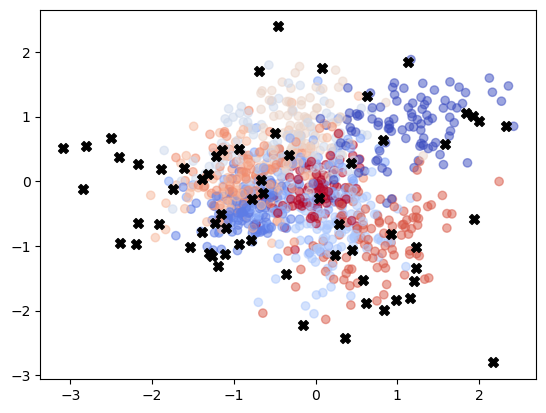

In [10]:
import matplotlib.pyplot as plt
# Visualize the points in the feature space
plt.scatter(encoder1(X_train[:1000])[:, 0], encoder1(X_train[:1000])[:, 1], alpha=0.5, c=y_train[:1000], cmap=plt.cm.coolwarm)

# plot the prototypes
plt.scatter(qkm_mnist.qkm.c_x.numpy()[:, 0], qkm_mnist.qkm.c_x.numpy()[:, 1], c='k', marker='X', s=50)
plt.show()

The figure above show training samples mapped to the latent space with different colors according to the class. The prototypes are shown as black crosses. Note that the prototypes do not cover all the areas of the different classes in the latent space, rather they are positioned to maximize the classification performance.

In [11]:
# Evaluate the classifier
score = qkm_mnist.evaluate(X_test, y_test, verbose=0)
print('QKM Test loss:', score[0])
print('QKM Test accuracy:', score[1])
score = qkm_mnist.evaluate(X_train, y_train, verbose=0)
print('QKM Train loss:', score[0])
print('QKM Train accuracy:', score[1])
print(f'QKM Sigma: {qkm_mnist.kernel.sigma.numpy()}')

QKM Test loss: 0.3751537501811981
QKM Test accuracy: 0.9070000052452087
QKM Train loss: 0.043304767459630966
QKM Train accuracy: 0.989145815372467
QKM Sigma: 1.164527177810669


Now we will train a density estimation model using the QKMJointDenEstModel class and keeping the encoder fix. This model maximizes the joint likelihood of inputs and outputs. The goal is to obtain more representative prototypes, since the prototypes learned using the classification model are not representative of the data distribution, since them are optimized to maximize the classification accuracy.

In [12]:
n_comp = 300
encoder2 = create_encoder(input_shape, base_depth, encoded_size)
encoder2.set_weights(encoder1.get_weights())

mqkm_model = MemQKMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder2,
                            n_comp=n_comp,
                            sigma=qkm_mnist.kernel.sigma.numpy())

# init the memory
mqkm_model.create_index(X_train, np.eye(10)[y_train])
X_train_ds = mqkm_model.create_train_ds(batch_size=32)
X_test_ds = mqkm_model.create_test_ds(X_test, np.eye(10)[y_test], batch_size=32)
X_pred_ds = mqkm_model.create_predict_ds(X_test)

mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])

  11/1500 [..............................] - ETA: 15s

2023-08-23 15:29:40.137134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 22s 14ms/step


2023-08-23 15:30:02.521069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [13]:
scores = []
mult = [2 ** i for i in range(-5, 4, 1)]
for m in mult:
    mqkm_model.kernel.sigma.assign(qkm_mnist.kernel.sigma.numpy() * m)
    score = mqkm_model.evaluate(X_test_ds, verbose=0)
    print(mqkm_model.kernel.sigma.numpy())
    print('Mem QKM Test loss:', score[0])
    print('Mem QKM Test accuracy:', score[1])
    scores.append(score)


2023-08-23 15:30:28.997842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 15:30:29.029137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-23 15:30:29.787889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.036391474
Mem QKM Test loss: 0.39138421416282654
Mem QKM Test accuracy: 0.9053999781608582
0.07278295
Mem QKM Test loss: 0.39138662815093994
Mem QKM Test accuracy: 0.9053999781608582
0.1455659
Mem QKM Test loss: 0.3940608501434326
Mem QKM Test accuracy: 0.9057999849319458
0.2911318
Mem QKM Test loss: 0.576728105545044
Mem QKM Test accuracy: 0.9060999751091003
0.5822636
Mem QKM Test loss: 0.42695894837379456
Mem QKM Test accuracy: 0.9078999757766724
1.1645272
Mem QKM Test loss: 0.3933302164077759
Mem QKM Test accuracy: 0.9063000082969666
2.3290544
Mem QKM Test loss: 0.3917199373245239
Mem QKM Test accuracy: 0.9056000113487244
4.6581087
Mem QKM Test loss: 0.3914749026298523
Mem QKM Test accuracy: 0.9054999947547913
9.316217
Mem QKM Test loss: 0.3914209306240082
Mem QKM Test accuracy: 0.9054999947547913


In [14]:
X_pred_ds[0].shape, X_pred_ds[1].shape
neigh_x =  tf.gather(mqkm_model.samples_x, X_pred_ds[1], axis=0)
# Calculate the distance between the query and the neighbors
dist = tf.norm(X_pred_ds[0][:, tf.newaxis, :] - neigh_x, axis=2)
# Calculate the average, min and max distance
avg_dist = tf.reduce_mean(dist, axis=1)
min_dist = tf.reduce_min(dist, axis=1)
max_dist = tf.reduce_max(dist, axis=1)
# plot a histogram of the distances


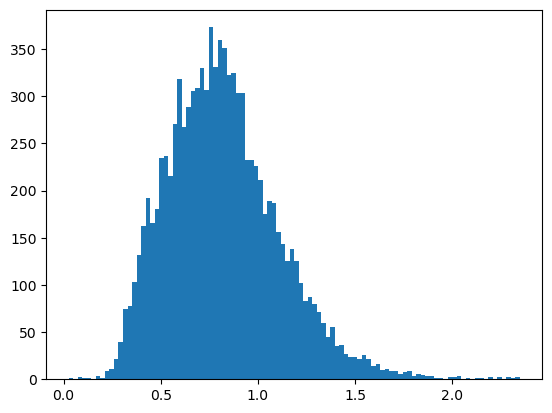

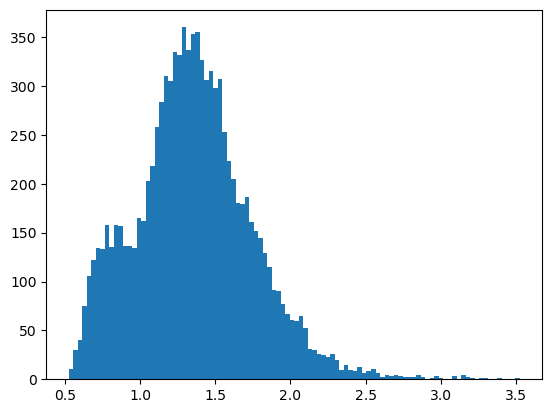

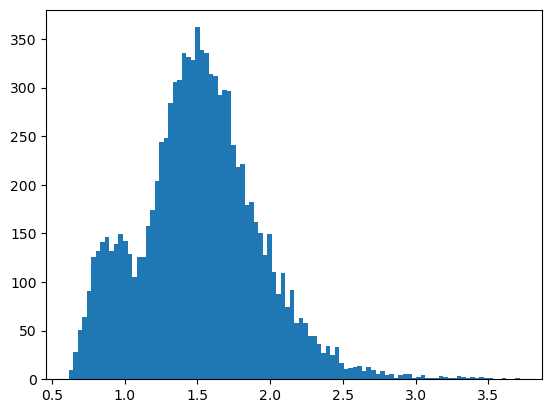

In [15]:
import matplotlib.pyplot as plt
plt.hist(min_dist.numpy(), bins=100)
plt.show()

plt.hist(avg_dist.numpy(), bins=100)
plt.show()

plt.hist(max_dist.numpy(), bins=100)
plt.show()


In [16]:

mqkm_model.kernel.sigma.assign(5)
mqkm_model.predict((X_pred_ds[0][0:2], X_pred_ds[1][0:2]) ,  verbose=0)

2023-08-23 15:31:27.852475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.9999999],
       [0.       , 0.       , 1.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       ]], dtype=float32)

In [17]:
X_pred_ds[0].shape, X_pred_ds[1].shape

(TensorShape([10000, 16]), TensorShape([10000, 300]))

In [18]:
from qkm.tf.layers import MemRBFKernelLayer, MemQKMLayer, RBFKernelLayer


mrbfk = MemRBFKernelLayer(sigma=0.5, dim=64)
rbfk = RBFKernelLayer(sigma=0.5, dim=64)
mqkm = MemQKMLayer(kernel=mrbfk, dim_x=64, dim_y=1, n_comp=200)

x_enc, neighbors = X_pred_ds[0][:20], X_pred_ds[1][:20]
x_neigh = tf.gather(mqkm_model.samples_x, neighbors, axis=0)
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
rho_y = mqkm([x_enc, x_neigh, y_neigh])
print(rho_y[0, :10, 0])

tf.Tensor(
[0.03411194 0.03198439 0.02851921 0.0252539  0.0216475  0.0183493
 0.01620086 0.0136059  0.01352022 0.01349683], shape=(10,), dtype=float32)


In [19]:
in_v = tf.expand_dims(x_enc, axis=1) # shape (bs, 1, dim_x)
out_vw = mrbfk(in_v, x_neigh)
out_vw_1 = rbfk(in_v, x_neigh[0])
print (out_vw.shape)
print(out_vw[0,0,:10] ** 2)
print(out_vw_1[0,0,:10] ** 2)

(20, 1, 300)
tf.Tensor(
[0.45210585 0.42390808 0.3779821  0.33470502 0.28690717 0.2431942
 0.21471964 0.1803271  0.17919157 0.1788815 ], shape=(10,), dtype=float32)
tf.Tensor(
[0.45210585 0.42391136 0.3779821  0.33470502 0.28690502 0.24319604
 0.214718   0.1803285  0.17918883 0.17888285], shape=(10,), dtype=float32)


In [20]:
np.sum(y_neigh,axis=1)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 300.],
       [  0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  3.,   0.,   0.,   0.,   0.,   0., 297.,   0.,   0.,   0.],
       [  0., 300.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., 300.,   0.,   0.],
       [  0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 213.,   0.,  84.,   3.,   0.],
       [  0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  85.,   0., 21

In [21]:
print(y_neigh[8, :10])

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)


In [53]:
qkm_mnist.kernel.sigma.assign(5)
qkm_mnist.predict(X_test[:2], verbose=0)

array([[1.14879615e-04, 5.51695994e-05, 7.83121504e-05, 6.73886680e-05,
        6.80981902e-05, 7.99595437e-05, 1.33094436e-04, 9.99308944e-01,
        4.09124877e-05, 5.33210768e-05],
       [6.11804790e-05, 2.23394691e-05, 9.99747813e-01, 1.04540923e-05,
        5.60874978e-05, 5.71921191e-06, 4.64761761e-05, 2.53393737e-05,
        2.52210566e-06, 2.21634091e-05]], dtype=float32)

In [22]:
# train the classifier
mqkm_model.kernel.sigma.assign(1.)
mqkm_model.compile(optimizer=optimizers.Adam(lr=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
print(f"Initial sigma: {mqkm_model.kernel.sigma.numpy()}")
mqkm_model.fit(X_train_ds, epochs=2, verbose=1)
print(f"FInal sigma: {mqkm_model.kernel.sigma.numpy()}")


Initial sigma: 1.0
Epoch 1/2


2023-08-23 15:33:19.406793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 31s 20ms/step - loss: 0.0332 - categorical_accuracy: 0.9910
Epoch 2/2
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0301 - categorical_accuracy: 0.9907
FInal sigma: 0.46307364106178284


In [23]:
score = mqkm_model.evaluate(X_test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



2023-08-23 15:34:18.975447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.48399585485458374
Test accuracy: 0.9085999727249146


In [34]:
encoder2.set_weights(encoder1.get_weights())


In [34]:
neighbors =  X_pred_ds[1]
y_neigh = tf.gather(mqkm_model.samples_y, neighbors, axis=0)
y_pred = np.argmax(y_neigh, axis=1)
y_neigh.shape

TensorShape([10000, 300, 10])

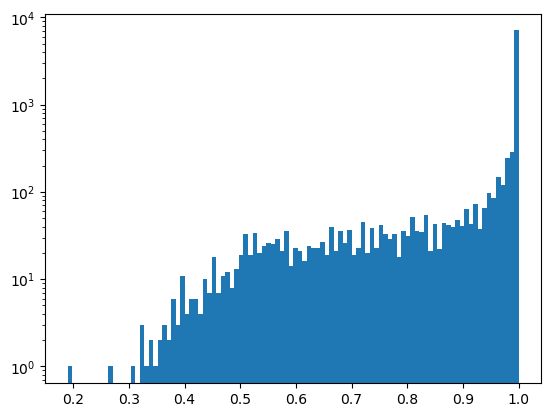

In [29]:
y_avg = np.mean(y_neigh, axis=1)
plt.hist(np.max(y_avg, axis=1), bins=100, log=True);

In [35]:
from sklearn.metrics import accuracy_score  
y_pred = np.argmax(y_avg, axis=1)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9054
